# Further Analysis of first and last day of sight in Kaliningrad

This notebook focuses on vanessa atalanta (migratory) and Inachis io (local). The output/figures of this notebook are stored in the _first-last-day_ subdirectory.

In [1]:
# import libraries
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

# import (personal) functions & variables
from funcs import import_pickled_data, which_cols, number_of_day_to_date, highlight_years, first_last_day
from vals import sheets, yrs
species, species_long, species_summed = import_pickled_data()

### Is the temperature of the Kaliningrad dataset comparable to external measurements?

First, let's plot the tempertature per year in a single figure. Pandas' Timestamp doesn't work
without a year, so we'll add a new column _dys_ to the data table holding the number of days since Jan 1st. In order to compute the difference, we'll use pandas' Timedelta class. More info can be found in the [docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html).

In [2]:
def import_data(sheet):
    # import single dataset
    df = species[sheet].reset_index()
    # compute difference in days from Jan 1st of respective year
    df['dummy'] = [df.datetime[i] - pd.to_datetime(str(df.Year[i])+'-1-1') for i in range(len(df.index))]
    # transform difference in integers
    df['dys'] = df['dummy'].dt.days
    # and drop dummy column
    df = df.drop('dummy', axis='columns')
    df.name = sheet
    return df

va = import_data('Vanessa atalanta')
io = import_data('Inachis io')

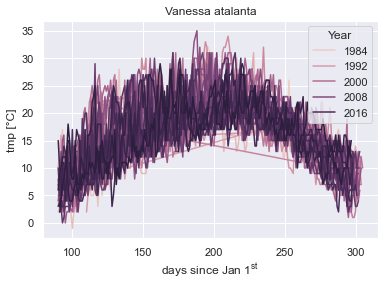

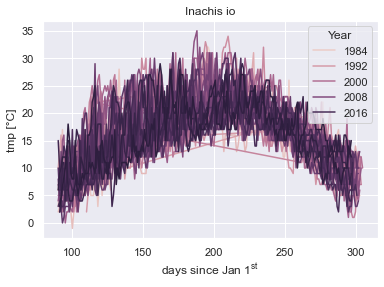

In [3]:
def plotting(df, savename):
    # plotting
    fig, ax = plt.subplots()
    sns.lineplot(
        data=df.query('Temp < 50'),
        x=df['dys'], y='Temp', hue='Year',
        ax=ax
    )
    ax.set_xlabel(r'days since Jan 1$^{\default{st}}$')
    ax.set_ylabel('tmp [°C]')
    ax.set_title(df.name)
    fig.savefig(f'../figs/first-last-day/{savename}_temperature_per_year.pdf', bbox_inches='tight')

plotting(va, 'va')
plotting(io, 'io')

In the following, the years are aggregated to show the mean and standard deviation. 

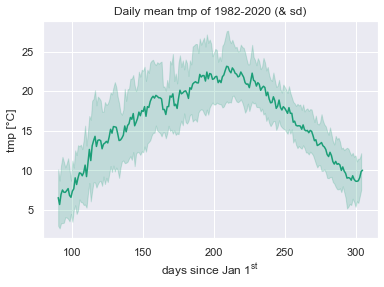

In [12]:
# more plotting...
fig, ax = plt.subplots()
sns.lineplot(
    data=va.query('Temp < 50'),
    x=va['dys'], y='Temp',
    ci='sd', # standard deviation of data
)
ax.set_title('Daily mean tmp of 1982-2020 (& sd)')
ax.set_xlabel(r'days since Jan 1$^{\default{st}}$')
ax.set_ylabel('tmp [°C]')
fig.savefig('../figs/first-last-day/temperature_aggregated.pdf', bbox_inches='tight')

### How does the temperature look like prior to the first day of sight?

In the following, the ultimate goal is to create a plot of _days vs tmp_, which displays the temperature history up to the point in time of the insects' first sight.

In [5]:
# remove temperature values that are higher than 50°C
va['Temp'].values[va.Temp > 50] = np.nan
# convert 'Year' values from python object to float
va['Year'] = va.Year.astype(float)
io['Year'] = io.Year.astype(float)

In [6]:
def process_data(df):
    # compute first day of sight
    first, _ = first_last_day(df)
    print(f'first days of sight of {df.name}:',first,'\n')

    # remove years without a sight
    # hence, grab indices of nan values
    i = np.argwhere(np.isnan(first))
    # update years and first day of sight accordingly
    yrs_no_nan = np.delete(yrs, i)
    first_no_nan = first[~np.isnan(first)]

    # grab indices of first day for every year
    ifirst = []
    for dy, yr in zip(first_no_nan,yrs_no_nan):
        ifirst.extend(df.loc[(df['Year'] == yr) & (df['dys'] == dy)].index.values)
    return yrs_no_nan, ifirst

va_yrs, va_ifirst = process_data(va)
io_yrs, io_ifirst = process_data(io)

No counts in 1987.
No counts in 1988.
No counts in 1989.
No counts in 1990.
No counts in 1991.
No counts in 1996.
first days of sight of Vanessa atalanta: [192. 135. 231. 220. 129.  nan  nan  nan  nan  nan 263. 147. 194. 149.
  nan 242. 151. 153. 130. 159. 122. 125. 175. 144. 143. 115. 153. 117.
 133. 139. 119. 137. 105. 141. 151. 142. 119. 106.  98.] 

No counts in 1988.
No counts in 1989.
No counts in 1991.
No counts in 2019.
first days of sight of Inachis io: [203. 108. 231. 109. 112. 120.  nan  nan 104.  nan 264. 191. 205. 104.
 113. 116. 111.  90. 105. 118. 110. 105. 108. 104. 116. 103. 104. 101.
 100. 107. 108. 107. 106.  98.  93.  99.  98.  nan  96.] 



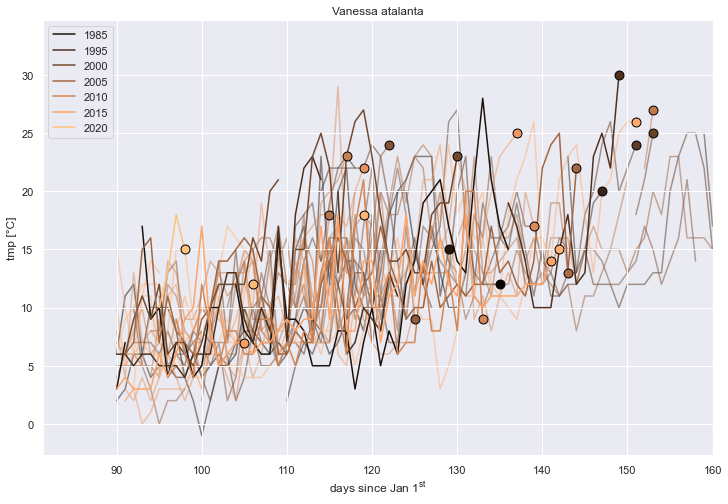

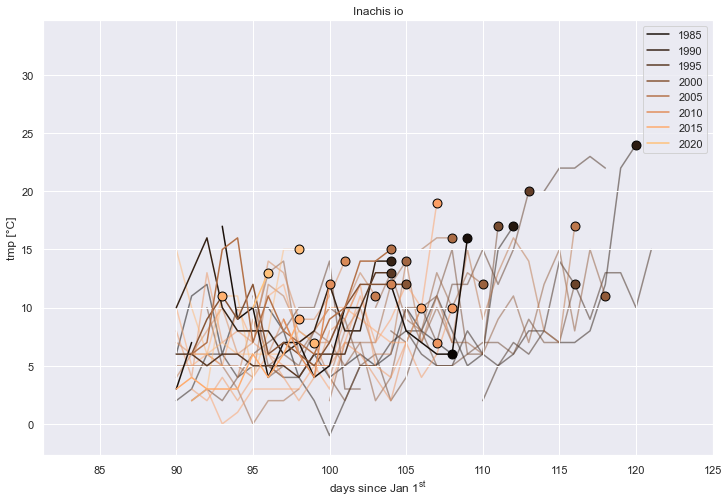

In [7]:
def visualise_data(df, yrs_no_nan, ifirst, savename):
    # adjusting continuous color mapcontinuous 
    ic = np.arange(0,1,1/len(yrs_no_nan))
    cmp = cm.copper

    fig, ax = plt.subplots(figsize=(12,8))
    # plot tmp trend up until first day of sight
    for i, yr in enumerate(yrs_no_nan):
        x = df.dys[:ifirst[i]+1][df.Year == yr].values
        y = df.Temp[:ifirst[i]+1][df.Year == yr].values
        if yr % 5 == 0:
            ax.plot(x, y, label=str(yr), color=cmp(ic[i]))
        else:
            ax.plot(x, y, color=cmp(ic[i]), alpha=0.5, zorder=0)
    # and overlay this with the day of first sight
        ax.scatter(df.dys[ifirst[i]], df.Temp[ifirst[i]], color=cmp(ic[i]), s=80,
                   edgecolor='k', zorder=10)
    # some beautification
    ax.legend()
    ax.set_xlabel(r'days since Jan 1$^{\default{st}}$')
    ax.set_ylabel('tmp [°C]')
    ax.set_title(df.name)
    if savename == 'va':
        ax.set_xlim(right=160)
    if savename == 'io':
        ax.set_xlim(right=125)
    fig.savefig(f'../figs/first-last-day/{savename}_tmp-trend_first-day_cropped.pdf',
                bbox_inches='tight')

visualise_data(va, va_yrs, va_ifirst, 'va')
visualise_data(io, io_yrs, io_ifirst, 'io')

Now, we'll create some additional plots to further understand the data.

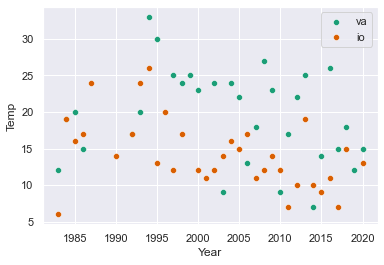

In [8]:
# create a scatter plot of the tmp at the first day of sight
fig, ax = plt.subplots()
sns.scatterplot(data=va.loc[va_ifirst], x='Year', y='Temp', ax=ax)
sns.scatterplot(data=io.loc[io_ifirst], x='Year', y='Temp', ax=ax)
ax.legend(labels=['va', 'io'])
plt.show()

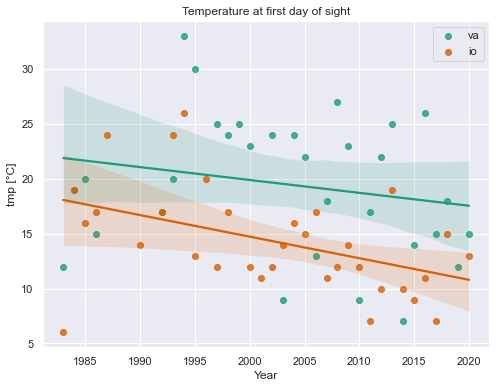

In [9]:
# create a linear regression plot of the tmp at the first day of sight
# to qualitatively identify any underlying trend...
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(data=va.loc[va_ifirst], x='Year', y='Temp', ax=ax, label='va')
sns.regplot(data=io.loc[io_ifirst], x='Year', y='Temp', ax=ax, label='io')
ax.legend()
ax.set_ylabel('tmp [°C]')
ax.set_title('Temperature at first day of sight')
fig.savefig('../figs/first-last-day/tmp-at-first-day_per-year.pdf',
            bbox_inches='tight')

1993
----
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 20. 22. 22. 23. 22. nan nan nan]


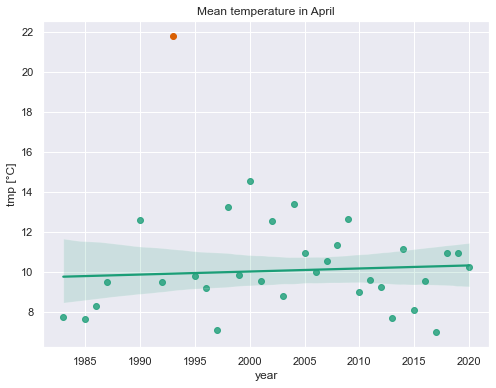

In [10]:
# plotting mean temperature of april
fig, ax = plt.subplots(figsize=(8,6))
fin = 31+1

# compute mean tmp in april and standard deviation
tmp_mean_apr = np.zeros(len(yrs))
tmp_mean_apr_std = np.zeros(len(yrs))
for i, y in enumerate(yrs):
    tmp_mean_apr[i] = va.Temp[va.Year == y][:fin].mean()
    tmp_mean_apr_std[i] = va.Temp[va.Year == y][:fin].std()

# delete nan's
i = np.argwhere(np.isnan(tmp_mean_apr))
tmp_mean_apr_no_nan = np.delete(tmp_mean_apr, i)
tmp_mean_apr_std_no_nan = np.delete(tmp_mean_apr_std, i)
yrs_tmp_no_nan = np.delete(yrs, i)

#plt.errorbar(yrs_no_nan, tmp_mean_apr_no_nan, yerr=tmp_mean_apr_std_no_nan)
#plt.scatter(yrs, tmp_mean_apr)

# the tmp data of 1993 is very much biased, let's remove it
print('1993\n----\n',va.Temp[va.Year == 1993][:fin].values)
sns_yrs = np.delete(yrs, 11)
sns_tmp = np.delete(tmp_mean_apr, 11)

# plotting...
sns.regplot(x=sns_yrs, y=sns_tmp, ax=ax)
ax.scatter(yrs[11], tmp_mean_apr[11], color=cm.Dark2(0.2))
ax.set_xlabel('year')
ax.set_ylabel('tmp [°C]')
ax.set_title('Mean temperature in April')
plt.show()

### Conclusion

Throughout the years:
- First year's record of V. atalanta and Inachis io was earlier
- Mean temperature in April stayed relatively constant
- Therefore, the species' first day of sight tended to be __colder__

This might indicate that the research people in Kaliningrad recorded more rigorous data
as time progressed and experience (?) increased.